In [ ]:
!pip install keras==2.6.0

     |████████████████████████████████| 1.3 MB 5.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.6.0 which is incompatible.


In [ ]:
import numpy as np # linear algebra
import pandas as pd 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS/training/dataset2-lemma.csv')

from sklearn.utils import shuffle
#df = shuffle(df)

df.head(250)
#df = df.drop(labels=range(250, 300), axis=0)

,id,tweet,text_processed,class
0,"1,48236E+18",Fabin Sanabria no era el que por lambonearle a...,fabin sanabrio lambonearle presidente santo as...,2
1,"1,48236E+18",la dualidad de una mujer de querer coquetearle...,dualidad mujer querer coquetear él mundo vez q...,2
2,"1,48236E+18",No precisaron la edad de cuando se hizo cura ...,precisar edad hacer cura l decir lola varios n...,2
3,"1,48236E+18",Esta hija de un montonero y mujer de un camale...,hija montonero mujer camalar peronacho penoso ...,2
4,"1,48236E+18",Una mujer abierta a comprender y a tr...,mujer abierto comprender trabajar necesidad di...,0
...,...,...,...,...
245,39,Callate perra,callate perra negro,1
246,43,Callate perra al rato empedamos,callate perra rato empedar,1
247,44,Que por cierto Danna Paola tu eres una gata as...,cierto gata asqueroso soportable zorra celos...,1
248,45,Callate maldita escoria! Acaso no sabes con qu...,callate malditar escorio acaso saber habla des...,1


In [ ]:
print(df.columns.values)
print(df.dtypes)
df = shuffle(df)


df.drop(df[df['class'] == 2].index, inplace = True)

test_df = df

['id' 'tweet' 'text_processed' 'class']
id                object
tweet             object
text_processed    object
class              int64
dtype: object


In [ ]:
df =df.dropna()
df = df.drop_duplicates()
df.count()

id                305
tweet             305
text_processed    305
class             305
dtype: int64

In [ ]:
def seq_len(text):
    return len(text.split(' '))

df['len'] = df.text_processed.apply(lambda x: seq_len(x))
df.head()

,id,tweet,text_processed,class,len
327,122,A la mujer buscala delgada y limpia que gorda ...,sheila tarado mierdo okala mate trola mierdo s...,1,25
261,88,A la mujer buscala delgada y limpia que gorda ...,callate perra arrepentido,1,3
58,"1,48236E+18",Quien Florencia En hombre un cambio de DNI ...,florencia hombre cambio dni convertir mujer se...,1,22
396,14521535,"""""""RT : Ahora vivo mi vida acostada en la aren...",yoyo bailo money hora sentir yo empoderado,0,7
378,122,A la mujer buscala delgada y limpia que gorda ...,t imagina ser tanto nadie lado hermano solo go...,1,10


In [ ]:
print('Maximum sequence length is', df.len.max())
print('Minimum sequence length is', df.len.min())
print('Average sequence length is', df.len.mean())

Maximum sequence length is 34
Minimum sequence length is 1
Average sequence length is 9.531147540983607


In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(df['text_processed'])
y = np.array(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=327)

print('Train set contains {} entries'.format(len(X_train)))
print("Test set contains {} entries".format(len(y_test)))


Train set contains 244 entries
Test set contains 61 entries


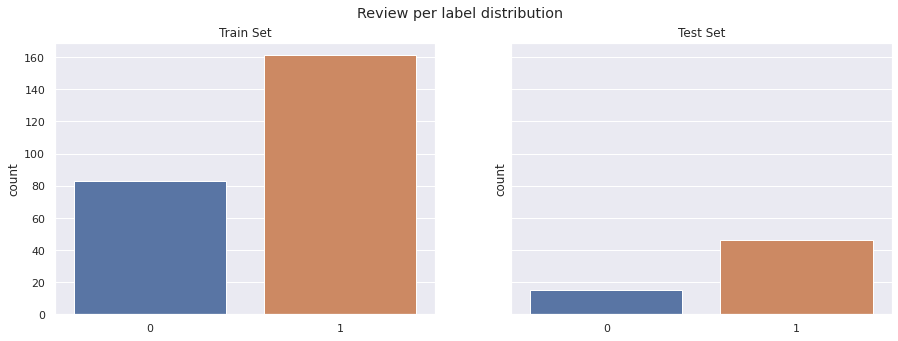

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import seaborn as sns
sns.set()

sns.set_theme(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Review per label distribution')
ax1 = sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Train Set')
ax2 = sns.countplot(x=y_test, ax=ax2)
ax2.set_title('Test Set')
plt.show()

In [ ]:
import nltk
import re
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, preprocessing
import warnings
warnings.filterwarnings('ignore')

In [ ]:
num_words = 10000 # the numer of words to tokenize 
max_seq = 50 # maximum sequence size


# fit the tokenizer on trainig texts
tokenizer = preprocessing.text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Dictionary of words ordered in terms of their frequency 
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f" {vocab_size-1} unique tokens found")
print(list(word_index)[:10])

 1242 unique tokens found
['mujer', 'gordo', 'mierda', 'decir', 'perra', 'mierdo', 'q', 'hacer', 'ser', 'puto']


In [ ]:
print("Original phrase:\n", X_train[0])
print()

# Turn the phrases into their numerical equivalents 
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print('Phrase as sequence:', X_train_seq[1])
print()

# Padding of our sequences 
X_train_processed = preprocessing.sequence.pad_sequences(X_train_seq, padding='post', maxlen=max_seq)
X_test_processed = preprocessing.sequence.pad_sequences(X_test_seq, padding='post', maxlen=max_seq)
print('Padded sequence:', X_train_processed[0])

Original phrase:
 colombiir todo mujer bonito hombre maluco pesar mujer colombiano sper difcil conseguir pareja comparado hombre misterioso camino seor fuente eclesiasts

Phrase as sequence: [316, 17, 317, 1, 318, 319, 320, 148, 321]

Padded sequence: [303 145   1 146  30 304 305   1 306 307 308 309 147 310  30 311 312 313
 314 315   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


**Carga de embeddings**

In [ ]:
embedding_index = {}
with open("/content/drive/MyDrive/Colab Notebooks/DS/training/SBW-vectors.txt") as f:
  for line in f:
    word, coef = line.split(maxsplit=1)
    coef = np.fromstring(coef, 'f', sep=' ')
    embedding_index[word] = coef 
print('{} embeddings found'.format(len(embedding_index)))

1000654 embeddings found


In [ ]:
embedding_dim = 300
hits = 0 
misses = 0

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for w, i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    hits+=1
    embedding_matrix[i] = embedding_vector
  else:
    misses += 1

print('{} words encoded with an embedding from SBW-vectors'.format(hits))
print('{} word embeddings not found'.format(misses))

1242 words encoded with an embedding from SBW-vectors
0 word embeddings not found


**Modelo Clasificador** 

---



In [ ]:
model = Sequential()

model.add(
    layers.Embedding(input_dim=vocab_size,
                     embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                     mask_zero=True,
                     output_dim=embedding_dim, # dimension of dense embedding. 
                     input_length=max_seq)
)

# LSTM layer
model.add(layers.LSTM(128))
# Dense output layer

model.add(layers.Dense(units=1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           372900    
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 592,677
Trainable params: 592,677
Non-trainable params: 0
_________________________________________________________________


In [ ]:
 history = model.fit(x=X_train_processed, y=y_train, epochs=7, batch_size=32, validation_data=(X_test_processed, y_test))
 

Epoch 1/7
8/8 [==============================] - 9s 212ms/step - loss: 0.6403 - accuracy: 0.6598 - val_loss: 0.5566 - val_accuracy: 0.7541
Epoch 2/7
8/8 [==============================] - 0s 13ms/step - loss: 0.6045 - accuracy: 0.6598 - val_loss: 0.5260 - val_accuracy: 0.7541
Epoch 3/7
8/8 [==============================] - 0s 14ms/step - loss: 0.5322 - accuracy: 0.7049 - val_loss: 0.4436 - val_accuracy: 0.7541
Epoch 4/7
8/8 [==============================] - 0s 14ms/step - loss: 0.3071 - accuracy: 0.8033 - val_loss: 0.3289 - val_accuracy: 0.8689
Epoch 5/7
8/8 [==============================] - 0s 13ms/step - loss: 0.1756 - accuracy: 0.9754 - val_loss: 0.4032 - val_accuracy: 0.8361
Epoch 6/7
8/8 [==============================] - 0s 13ms/step - loss: 0.1463 - accuracy: 0.9631 - val_loss: 0.3745 - val_accuracy: 0.8197
Epoch 7/7
8/8 [==============================] - 0s 13ms/step - loss: 0.0612 - accuracy: 0.9959 - val_loss: 0.2822 - val_accuracy: 0.8689


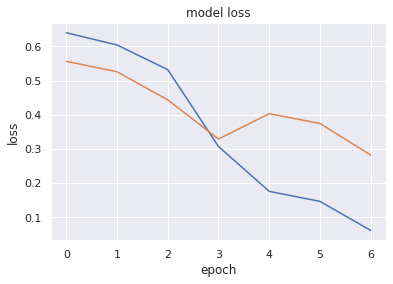

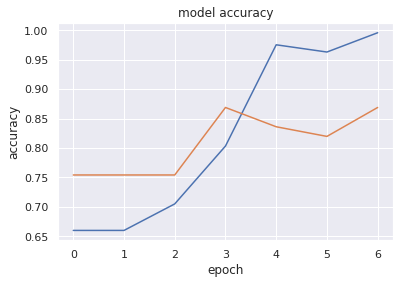

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()



In [ ]:
results = model.evaluate(X_test_processed, y_test, batch_size=32)
print("test loss, test acc:", results)

2/2 [==============================] - 0s 16ms/step - loss: 0.2822 - accuracy: 0.8689
test loss, test acc: [0.2821568250656128, 0.868852436542511]


In [ ]:
y_pred = model.predict(x=X_test_processed, batch_size=32)
y_pred = [0 if y < 0.5 else 1 for y in y_pred]

print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.83      0.90        46

    accuracy                           0.87        61
   macro avg       0.83      0.91      0.85        61
weighted avg       0.91      0.87      0.88        61

Accuracy: 0.8688524590163934


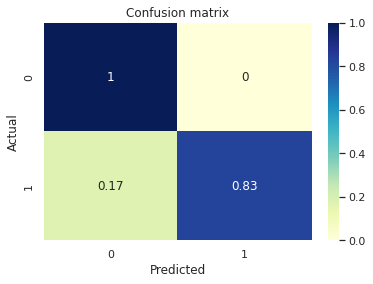

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

**Clasificación de un .csv** 

---



In [ ]:
lista = [1]
for j in lista:
  val = test_df
  X_val = val["text_processed"].fillna("fillna").values
 #X_val = "mujer empoderado"
  tokenizer = preprocessing.text.Tokenizer(num_words=max_seq)
  tokenizer.fit_on_texts(X_val)
  X_val = tokenizer.texts_to_sequences(X_val)
  x_val1 = preprocessing.sequence.pad_sequences(X_val, padding='post', maxlen=max_seq)
  
  data_d = []
  for i in range(len(x_val1)):
    single_test = x_val1[i:i+1]
    label = str(val["text_processed"][i:i+1].values)
    real = str(val["class"][i:i+1].values)
    #print(label) 
    pred1= model.predict(single_test)
    class_1  = ""
    #print(pred1)
    if pred1 <= 0.55:
        #print(f"Clasificacion: no violenta")
      class_1 = 0
    else:
        # print(f"Clasificacion: violenta")
      class_1=1
  
    #print(class_1)

    data_d.append([label,real,class_1,pred1])
    
  df = pd.DataFrame(data_d, columns=['tweet','class' ,'model','score'])
  df = df[df.tweet != '']
  df.head(60)
      

In [ ]:
  dir = '/content/drive/MyDrive/Colab Notebooks/DS/training/dataset_modelo.csv'
  df.to_csv(dir, index=False, header=True, encoding="utf-8")
  df.head(20)

,tweet,class,model,score
0,['mujer tanto bello interesante'],[0],0,[[0.1682575]]
1,['esque puto cllate piens m'],[1],1,[[0.95750886]]
2,['callate zorra mama duro'],[1],1,[[0.9244954]]
3,['q avez explicate gordo d mierdo'],[1],1,[[0.9780629]]
4,['amar prima contadorar ta solucionar bido muj...,[0],0,[[0.2935279]]
5,['cada vez q acuerdo gordo decir digooo tiento...,[1],1,[[0.9956032]]
6,['dios gordo mierda'],[1],1,[[0.9714514]]
7,['borralo gordo mierda'],[1],1,[[0.9714514]]
8,['di tú mio orgullo felicitación padre desear ...,[0],0,[[0.29282355]]
9,['cerdar envidiós pas mal puto vida merez agua...,[1],1,[[0.8211418]]


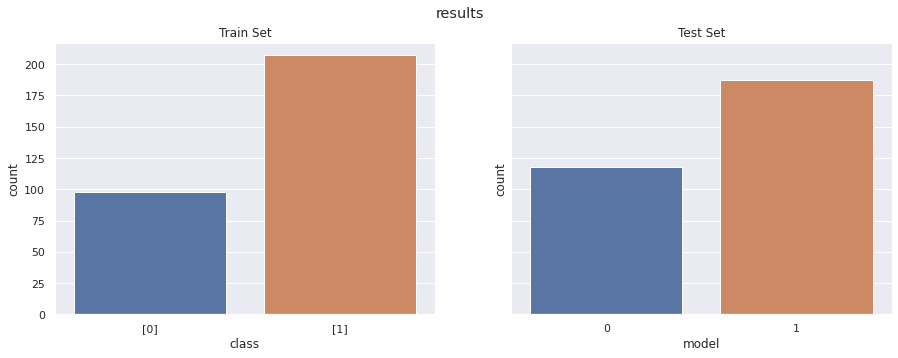

In [ ]:
sns.set()
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS/training/dataset_modelo.csv')
sns.set_theme(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('results')
ax1 = sns.countplot(x=df['class'], ax=ax1)
ax1.set_title('Train Set')
ax2 = sns.countplot(x=df['model'], ax=ax2)
ax2.set_title('Test Set')
plt.show()

**Clasificación individual**

---



In [ ]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
!pip install deplacy
!python -m spacy download es_core_news_sm
!python -m spacy download es

     |████████████████████████████████| 16.2 MB 24.7 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=5ba2158211c80d5fe251bd40a1efe2e2e7a990cbe7acb0a3922fb8043443b849
  Stored in directory: /tmp/pip-ephem-wheel-cache-z2bkzdfo/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
     |████████████████████████████████| 16.2 MB 28.8 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [ ]:
from nltk.tokenize import word_tokenize
    
def clasificar(text):
  sr = nltk.corpus.stopwords.words('spanish')
  word_tokens = word_tokenize(text)
  
  filtered_sentence = [w for w in word_tokens if not w.lower() in sr]
  
  filtered_sentence = ''
  
  for w in word_tokens:
      if w not in sr:
          filtered_sentence+= (w+' ')
  text = filtered_sentence
  
  # 5 lemma
  import pkg_resources,imp
  imp.reload(pkg_resources)
  import spacy
  nlp=spacy.load("es_core_news_sm")

  doc = nlp(text)
  single_text_processed = ''
  for token in doc: 
    single_text_processed += (token.lemma_+' ')
    #print(token.text, "|", token.lemma_, '|', token.pos_)
  
  X_val = val["text_processed"].fillna("fillna").values
  tokenizer = preprocessing.text.Tokenizer(num_words=max_seq)
  tokenizer.fit_on_texts(X_val)
  single_text_processed = tokenizer.texts_to_sequences([single_text_processed])
  single_text_processed = preprocessing.sequence.pad_sequences(single_text_processed, padding='post', maxlen=max_seq)
  pred= model.predict(single_text_processed)
  #print(pred)
  if pred <= 0.55: 
    return 'no violenta' 
  else: 
    return 'violenta'

In [ ]:
text = "te quiero mucho hermosa mujer"
print(clasificar(text))

no violenta


**Modelo Simple**

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train_processed, y_train) 
score = classifier.score(X_test_processed, y_test)

print("Precisión:", score)

Precisión: 0.6229508196721312
